In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# show all columns when displaying a data frame
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1.0 Data Preeprocessing

In [4]:
dtypes = {'country':'category', 'cat_name':'category', 'cat_slug':'category', 'loc_name':'category', 
'loc_country':'category', 'loc_state':'category', 'loc_type':'category', 'main_category':'category', 
'sub_category':'category', 'goal_categorical':'category', 'currency':'category', 'usd_type':'category'}
frame_all = pd.read_csv('data/Kickstarter_full.csv', index_col=0, parse_dates=['created_at', 'launched_at', 'deadline', 'state_changed_at'], dtype=dtypes)

In [5]:
columns = frame_all.columns

In [6]:
columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'created_at', 'currency', 'currency_symbol', 'currency_trailing_code',
       'current_currency', 'deadline', 'disable_communication', 'fx_rate',
       'goal', 'id', 'is_starrable', 'launched_at', 'name', 'pledged', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'usd_pledged', 'usd_type', 'dur_inactive',
       'dur_until_state_changed', 'dur_active', 'dur_ratio', 'cat_name',
       'cat_slug', 'loc_name', 'loc_country', 'loc_state', 'loc_type',
       'photo_thumb', 'photo_large', 'project_address', 'profile_photo',
       'creator_name', 'creator_id', 'creator_thumb', 'creator_address',
       'main_category', 'sub_category', 'goal_surpass', 'goal_surpass_share',
       'goal_surpass_usd', 'goal_usd', 'goal_categorical', 'blurb_words',
       'blurb_len', 'name_len', 'name_words', 'state_bool', 'baseline'],
      dtype='object')

In [7]:
to_delete = ['backers_count',
 'blurb',
 'created_at',
 'converted_pledged_amount',
 'currency_symbol',
 'currency_trailing_code',
 'current_currency',
 'deadline',
 'goal',
 'id',
 'is_starrable',
 'launched_at',
 'name',
 'pledged',
 'slug',
 'source_url',
 'spotlight',
 'staff_pick',
 'state',
 'state_changed_at',
 'usd_pledged',
 'cat_name',
 'cat_slug',
 'loc_name',
 'loc_country',
 'loc_state',
 'photo_thumb',
 'photo_large',
 'project_address',
 'profile_photo',
 'creator_name',
 'creator_id',
 'creator_thumb',
 'creator_address',
 'goal_surpass',
 'goal_surpass_share',
 'goal_surpass_usd',
 'baseline',
 'disable_communication',
 'goal_usd',
 'dur_until_state_changed',
 'dur_ratio',
 'fx_rate',
 'static_usd_rate',
 'blurb_words',
 'name_words'
 ]

# Additionally deleted: 
# Cannot be known a priori: 'dur_until_state_changed', 'dur_ratio'
# Somehow a duplicate: 'goal_usd', 'blurb_words', 'name_words'
# For other reasons: 'fx_rate', 'static_usd_rate'

In [8]:
frame_all.drop(columns=to_delete, inplace=True)

In [9]:
# Save category-column-names in list
categorical_cols = frame_all.select_dtypes(include='category').columns

# Create dummies
frame_all = pd.get_dummies(frame_all, columns = categorical_cols, drop_first=True)

In [10]:
# save numerical features in a list
num_features = frame_all.select_dtypes(include='number').columns.to_list()
num_features.remove('state_bool')

In [11]:
X = frame_all.drop('state_bool', axis=1)
y = frame_all.state_bool

In [12]:
RSEED=42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RSEED)

## Scaling

In [13]:
# scale the (few) numerical features
std = StandardScaler()
X_train_scaled = X_train.copy(deep=True)
X_test_scaled = X_test.copy(deep=True)
X_train_scaled[num_features] = std.fit_transform(X_train_scaled[num_features])
X_test_scaled[num_features] = std.transform(X_test_scaled[num_features])

# 2.0 Random Forest Model  - Jean-Claude Van Damme Model

In [66]:
# Features for feature importances
features = list(X_train_scaled.columns)

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=500, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               max_leaf_nodes=200,
                               min_samples_split=50,
                               max_depth=30,
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(X_train_scaled, y_train)


n_nodes = []
max_depths = []

# Stats about the trees in random forest
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

# Training predictions (to demonstrate overfitting)
train_rf_predictions = model.predict(X_train_scaled)
train_rf_probs = model.predict_proba(X_train_scaled)[:, 1]

# Testing predictions (to determine performance)
rf_predictions = model.predict(X_test_scaled)
rf_probs = model.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Average number of nodes 399
Average maximum depth 29


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[

In [51]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve


# Plot formatting
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

# Function for calculating the evaluation metrics and plotting the ROC-curve
# TODO: CHANGE BASELINE MODEL TO OURS?

def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(y_test, 
                                     [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, 
                                      [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 10
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); 
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
    plt.show();


In [52]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Function to plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Plot the confusion matrix
    plt.figure(figsize = (5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 15)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 10,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)


In [46]:
y_train.value_counts()

1    70913
0    55594
Name: state_bool, dtype: int64

## 2.1 Evaluation of the simple Random Forest Model

Recall Baseline: 1.0 Test: 0.82 Train: 0.82
Precision Baseline: 0.56 Test: 0.76 Train: 0.76
Roc Baseline: 0.5 Test: 0.85 Train: 0.85


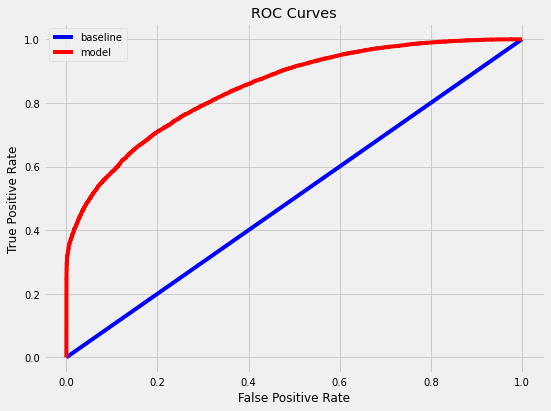

In [67]:
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)
# plt.savefig('image/nb1_roc_auc_curve.png')

Confusion matrix, without normalization
[[12321  6211]
 [ 4291 19347]]
Confusion matrix, without normalization
[[37327 18267]
 [12475 58438]]


/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_47671/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)
/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_47671/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)


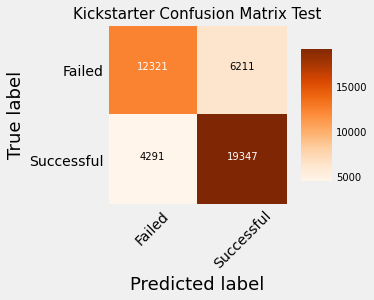

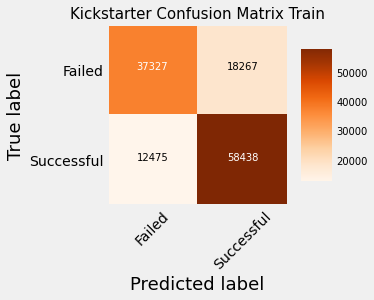

In [68]:
# Execute confusion matrices

# Confusion matrix TEST
cm_test = confusion_matrix(y_test, rf_predictions)
plot_confusion_matrix(cm_test, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Test')

# Confusion matrix TRAIN
cm_train = confusion_matrix(y_train, train_rf_predictions)
plot_confusion_matrix(cm_train, classes = ['Failed','Successful'],
                      title = 'Kickstarter Confusion Matrix Train')

# plt.savefig('image/nb1_cm.png')

In [69]:
# Execute classification matrices

cr_train = classification_report(y_train, train_rf_predictions)
print('Classification on train data')
print(cr_train)

cr_test = classification_report(y_test, rf_predictions)
print('Classification on test data')
print(cr_test)


Classification on train data
              precision    recall  f1-score   support

           0       0.75      0.67      0.71     55594
           1       0.76      0.82      0.79     70913

    accuracy                           0.76    126507
   macro avg       0.76      0.75      0.75    126507
weighted avg       0.76      0.76      0.76    126507

Classification on test data
              precision    recall  f1-score   support

           0       0.74      0.66      0.70     18532
           1       0.76      0.82      0.79     23638

    accuracy                           0.75     42170
   macro avg       0.75      0.74      0.74     42170
weighted avg       0.75      0.75      0.75     42170



In [392]:
# from sklearn.tree import plot_tree

# fig = plt.figure(figsize=(25,20))
# RF_tree_plot = plot_tree(model.estimators_[0], filled=True)

## 2.2 Calculate and plot feature Importance

In [56]:
# Check feature importances

fi_model = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

print("Top15 Features sorted by importance")
print(fi_model.head(15))

Top15 Features sorted by importance
                         feature  importance
0                   dur_inactive    0.127394
1                     dur_active    0.075143
52            main_category_food    0.062611
58      main_category_technology    0.040244
210   goal_categorical_500_to_5k    0.035222
3                       name_len    0.034878
205    goal_categorical_1_to_500    0.034519
196             sub_category_web    0.030559
94      sub_category_documentary    0.029620
176          sub_category_shorts    0.029138
138    sub_category_mobile games    0.026675
193     sub_category_video games    0.025664
123      sub_category_indie rock    0.025392
88   sub_category_country & folk    0.025099
144      sub_category_nonfiction    0.023368


Link to documentation:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

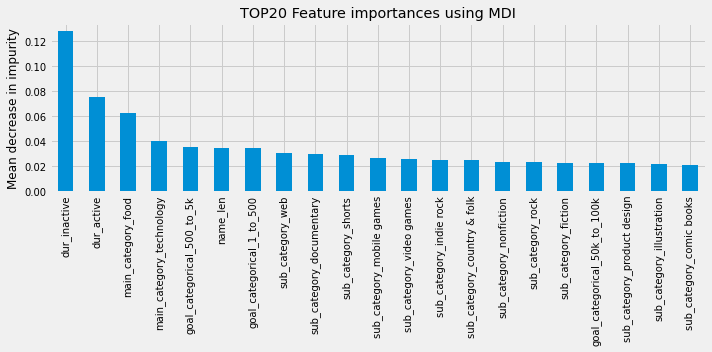

In [57]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
importances = model.feature_importances_
# std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

# forest_importances_test = pd.Series(importances, index=feature_names)

forest_importances_imp = pd.Series(importances, index=features)
forest_importances_imp_top20 = forest_importances_imp.sort_values(ascending=False).iloc[0:21]

fig, ax = plt.subplots(figsize=(10, 5))
forest_importances_imp_top20.plot.bar(ax=ax)
ax.set_title("TOP20 Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [468]:
 datetime.today().strftime('%Y-%m-%d')

'2022-04-03'

In [472]:
# Save permutation feature importances in a csv
transfer_csv = forest_importances_imp.reset_index().rename(columns={'index': 'feature', 0:'importance'}).sort_values('importance', ascending=False)
date =  datetime.today().strftime('%Y-%m-%d-%H_%M')
transfer_csv.to_csv(f'data/{date}_feature_importances_impurity.csv')

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_job

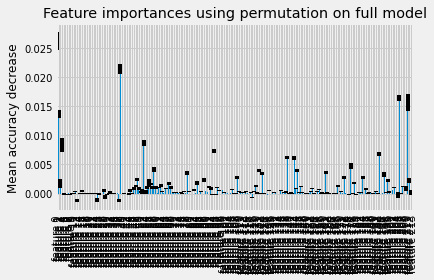

In [410]:
# Feature importance based on feature permutation¶
# ACHTUNG: DIESE BERECHNUNG HAT BEI MIR CA. 45 Minuten gedauert!!

# from sklearn.inspection import permutation_importance

# result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)




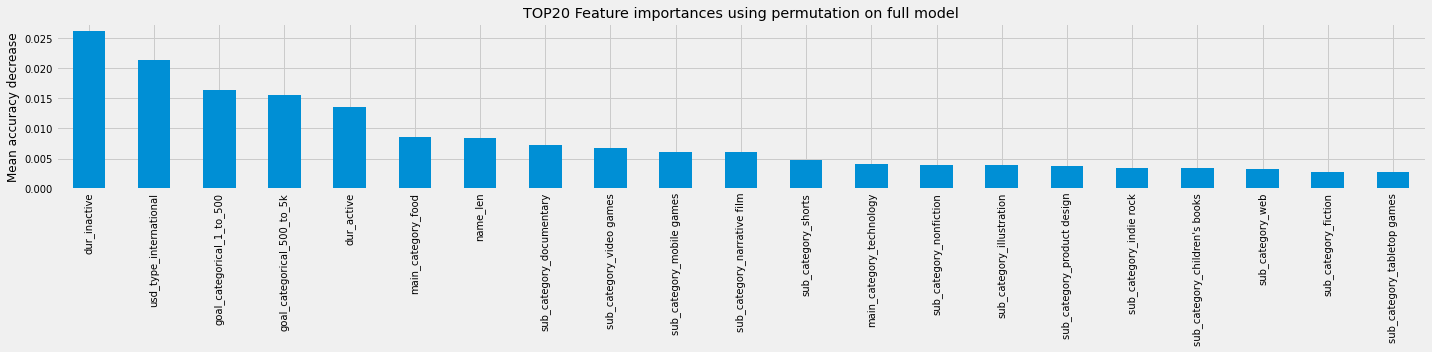

In [445]:
# forest_importances = pd.Series(result.importances_mean, index=features)
# importances_top20 = forest_importances.sort_values(ascending=False).iloc[0:21]

# fig, ax = plt.subplots(figsize=(20,5))
# importances_top20.plot.bar(ax=ax)
# ax.set_title("TOP20 Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

In [473]:
# Save permutation feature importances in a csv
# transfer_csv = forest_importances.reset_index().rename(columns={'index': 'feature', 0:'importance'}).sort_values('importance', ascending=False)
# date =  datetime.today().strftime('%Y-%m-%d-%H_%M')
# transfer_csv.to_csv(f'data/{date}_feature_importances_permutation.csv')

# 3.0 Randomized Search - Bruce Lee Model

In [70]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 300).astype(int),
    'max_depth': [None] + list(np.linspace(3, 40).astype(int)),
    'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [5, 10, 20, 30, 50],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'accuracy', cv = 3, 
                        n_iter = 10, verbose = 5, random_state=RSEED)

# Fit 
rs.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 3/3] END bootstrap=False, max_depth=12, max_features=0.6, max_leaf_nodes=26, min_samples_split=20, n_estimators=110;, score=0.689 total time= 1.2min
[CV 2/3] END bootstrap=False, max_depth=12, max_features=0.6, max_leaf_nodes=26, min_samples_split=20, n_estimators=110;, score=0.696 total time= 1.2min
[CV 1/3] END bootstrap=False, max_depth=12, max_features=0.6, max_leaf_nodes=26, min_samples_split=20, n_estimators=110;, score=0.695 total time= 1.3min
[CV 1/3] END bootstrap=True, max_depth=18, max_features=auto, max_leaf_nodes=22, min_samples_split=5, n_estimators=234;, score=0.726 total time=  21.6s
[CV 2/3] END bootstrap=True, max_depth=18, max_features=auto, max_leaf_nodes=22, min_samples_split=5, n_estimators=234;, score=0.727 total time=  21.9s
[CV 3/3] END bootstrap=False, max_depth=6, max_features=0.7, max_leaf_nodes=15, min_samples_split=5, n_estimators=223;, score=0.677 total time= 1.9min
[CV 2/3] END bootstrap=Fa

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 3, 3, 4, 5, 6, 6, 7,
                                                      8, 9, 9, 10, 11, 12, 12,
                                                      13, 14, 15, 15, 16, 17,
                                                      18, 18, 19, 20, 21, 21,
                                                      22, 23, 24, ...],
                                        'max_features': ['auto', 'sqrt', None,
                                                         0.5, 0.6, 0.7,
                                                         0.7999999999999999,
                                                         0.8999999999999999],
                                        'max_leaf_nodes': [None, 10, 10, 10, 10...
                                                 

In [71]:
rs.best_params_

{'n_estimators': 81,
 'min_samples_split': 5,
 'max_leaf_nodes': 41,
 'max_features': 'sqrt',
 'max_depth': 33,
 'bootstrap': False}

## 3.1 Evaluation of the model from randomized grid search

Average number of nodes 81
Average maximum depth 21
Recall Baseline: 1.0 Test: 0.82 Train: 0.83
Precision Baseline: 0.56 Test: 0.73 Train: 0.74
Roc Baseline: 0.5 Test: 0.83 Train: 0.83


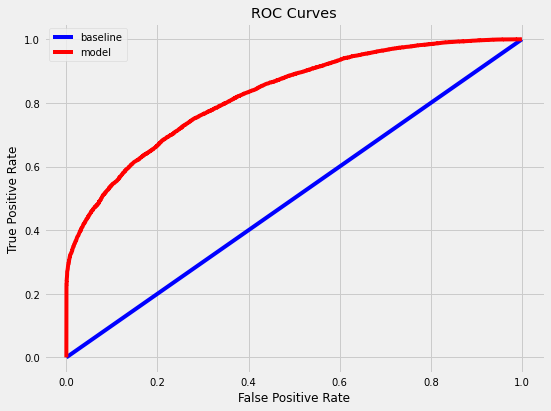

In [72]:
best_model = rs.best_estimator_

R_train_rf_predictions = best_model.predict(X_train_scaled)
R_train_rf_probs = best_model.predict_proba(X_train_scaled)[:, 1]

R_rf_predictions = best_model.predict(X_test_scaled)
R_rf_probs = best_model.predict_proba(X_test_scaled)[:, 1]

n_nodes = []
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

evaluate_model(R_rf_predictions, R_rf_probs, R_train_rf_predictions, R_train_rf_probs)

In [40]:
print(len(R_train_rf_probs))
print(len(R_rf_probs))

126507
42170


Confusion matrix, without normalization
[[11452  7080]
 [ 4157 19481]]
Confusion matrix, without normalization
[[34423 21171]
 [12174 58739]]


/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_47671/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)
/var/folders/_2/0mbl5gkd02l3mjd7fnqkpl1c0000gn/T/ipykernel_47671/2516166632.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(aspect=4)


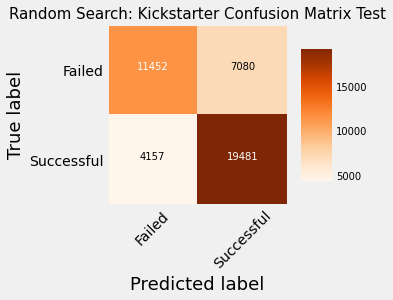

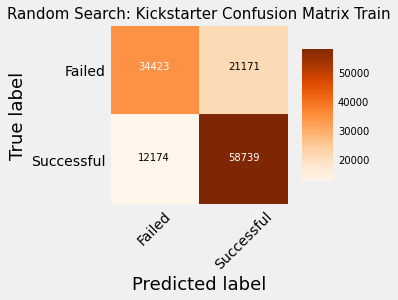

In [73]:
# Execute confusion matrices

# Confusion matrix TEST
cm_R_test = confusion_matrix(y_test, R_rf_predictions)
plot_confusion_matrix(cm_R_test, classes = ['Failed','Successful'],
                      title = 'Random Search: Kickstarter Confusion Matrix Test')

# Confusion matrix TRAIN
cm_R_train = confusion_matrix(y_train, R_train_rf_predictions)
plot_confusion_matrix(cm_R_train, classes = ['Failed','Successful'],
                      title = 'Random Search: Kickstarter Confusion Matrix Train')

In [74]:
# Execute classification matrices

cr_R_train = classification_report(y_train, R_train_rf_predictions)
print('Classification on train data')
print(cr_R_train)

cr_R_test = classification_report(y_test, R_rf_predictions)
print('Classification on test data')
print(cr_R_test)

Classification on train data
              precision    recall  f1-score   support

           0       0.74      0.62      0.67     55594
           1       0.74      0.83      0.78     70913

    accuracy                           0.74    126507
   macro avg       0.74      0.72      0.73    126507
weighted avg       0.74      0.74      0.73    126507

Classification on test data
              precision    recall  f1-score   support

           0       0.73      0.62      0.67     18532
           1       0.73      0.82      0.78     23638

    accuracy                           0.73     42170
   macro avg       0.73      0.72      0.72     42170
weighted avg       0.73      0.73      0.73     42170



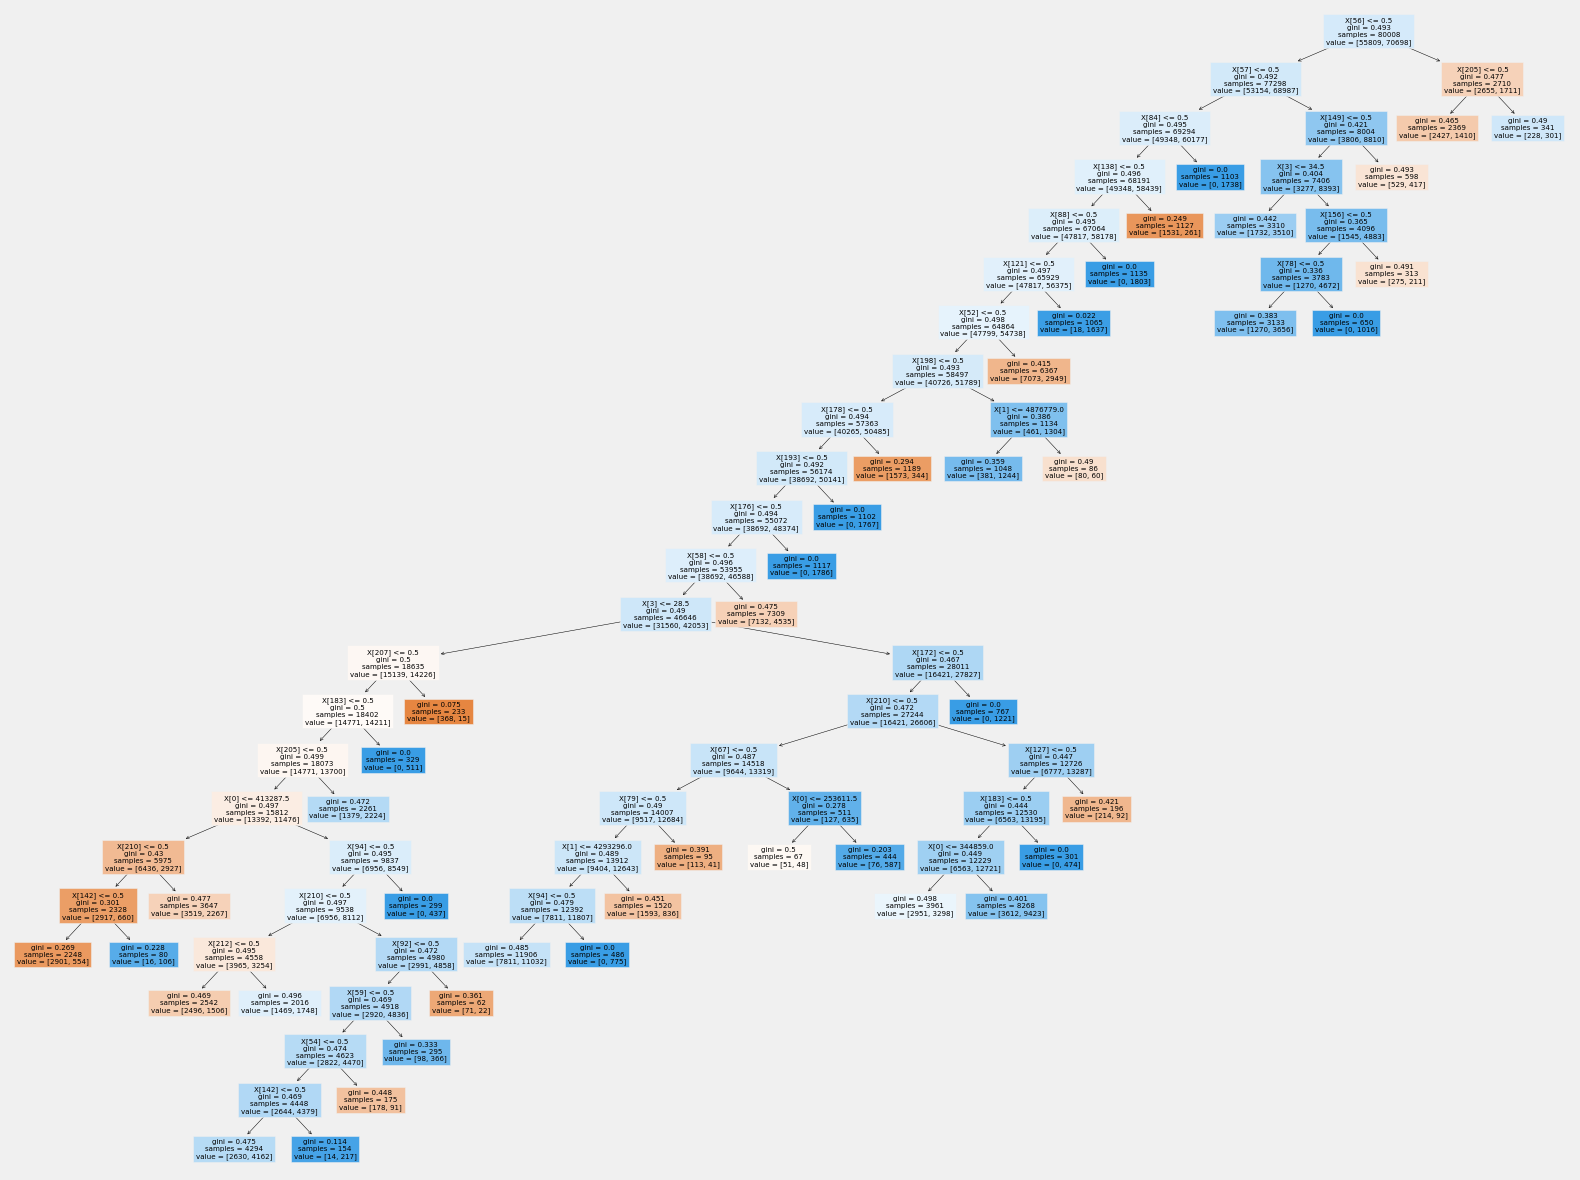

In [403]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(best_model.estimators_[0], filled=True)